In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [174]:
import io
%cd "/Users/rajeshprabhakarkaila/Desktop/Datasets/MovieLens"

/Users/rajeshprabhakarkaila/Desktop/Datasets/MovieLens


In [175]:
moviesdf=pd.read_csv("movies_metadata.csv",low_memory=False)

In [176]:
ratingsdf=pd.read_csv("ratings_small.csv")

In [177]:
# Recommender Systems or Recommendation Engines - Suggest similar items based on profile,
# pattern, usage, feedback, etc.

# 2 Types of Recommender systems that are widely used are
# 1) Collaborative Filtering - Recommendations are based on similarity measures like ratings
# between users and items. Basic assumption is users with similar interest will have 
# common preferences.
# Collaborative Filtering uses a User Item Matrix to generate recommendtations. The matrix
# contains values that indicate user preferences to a particular item.

# Users Prefernces can be both
# a) Explicit Feedback - Ratings, Scores, Stars, Votes, Reviews(text), etc.
# b) Implicit Feedback - Indirect user behavior like number of times watched, number of
# times saved, recommendation sharing, etc.

# 2) Content Based Recommendation System - Content like reviews, description/overview,
# customer feedback etc. in form of text. Natural Language Processing techniques are used
# in this recommender systems

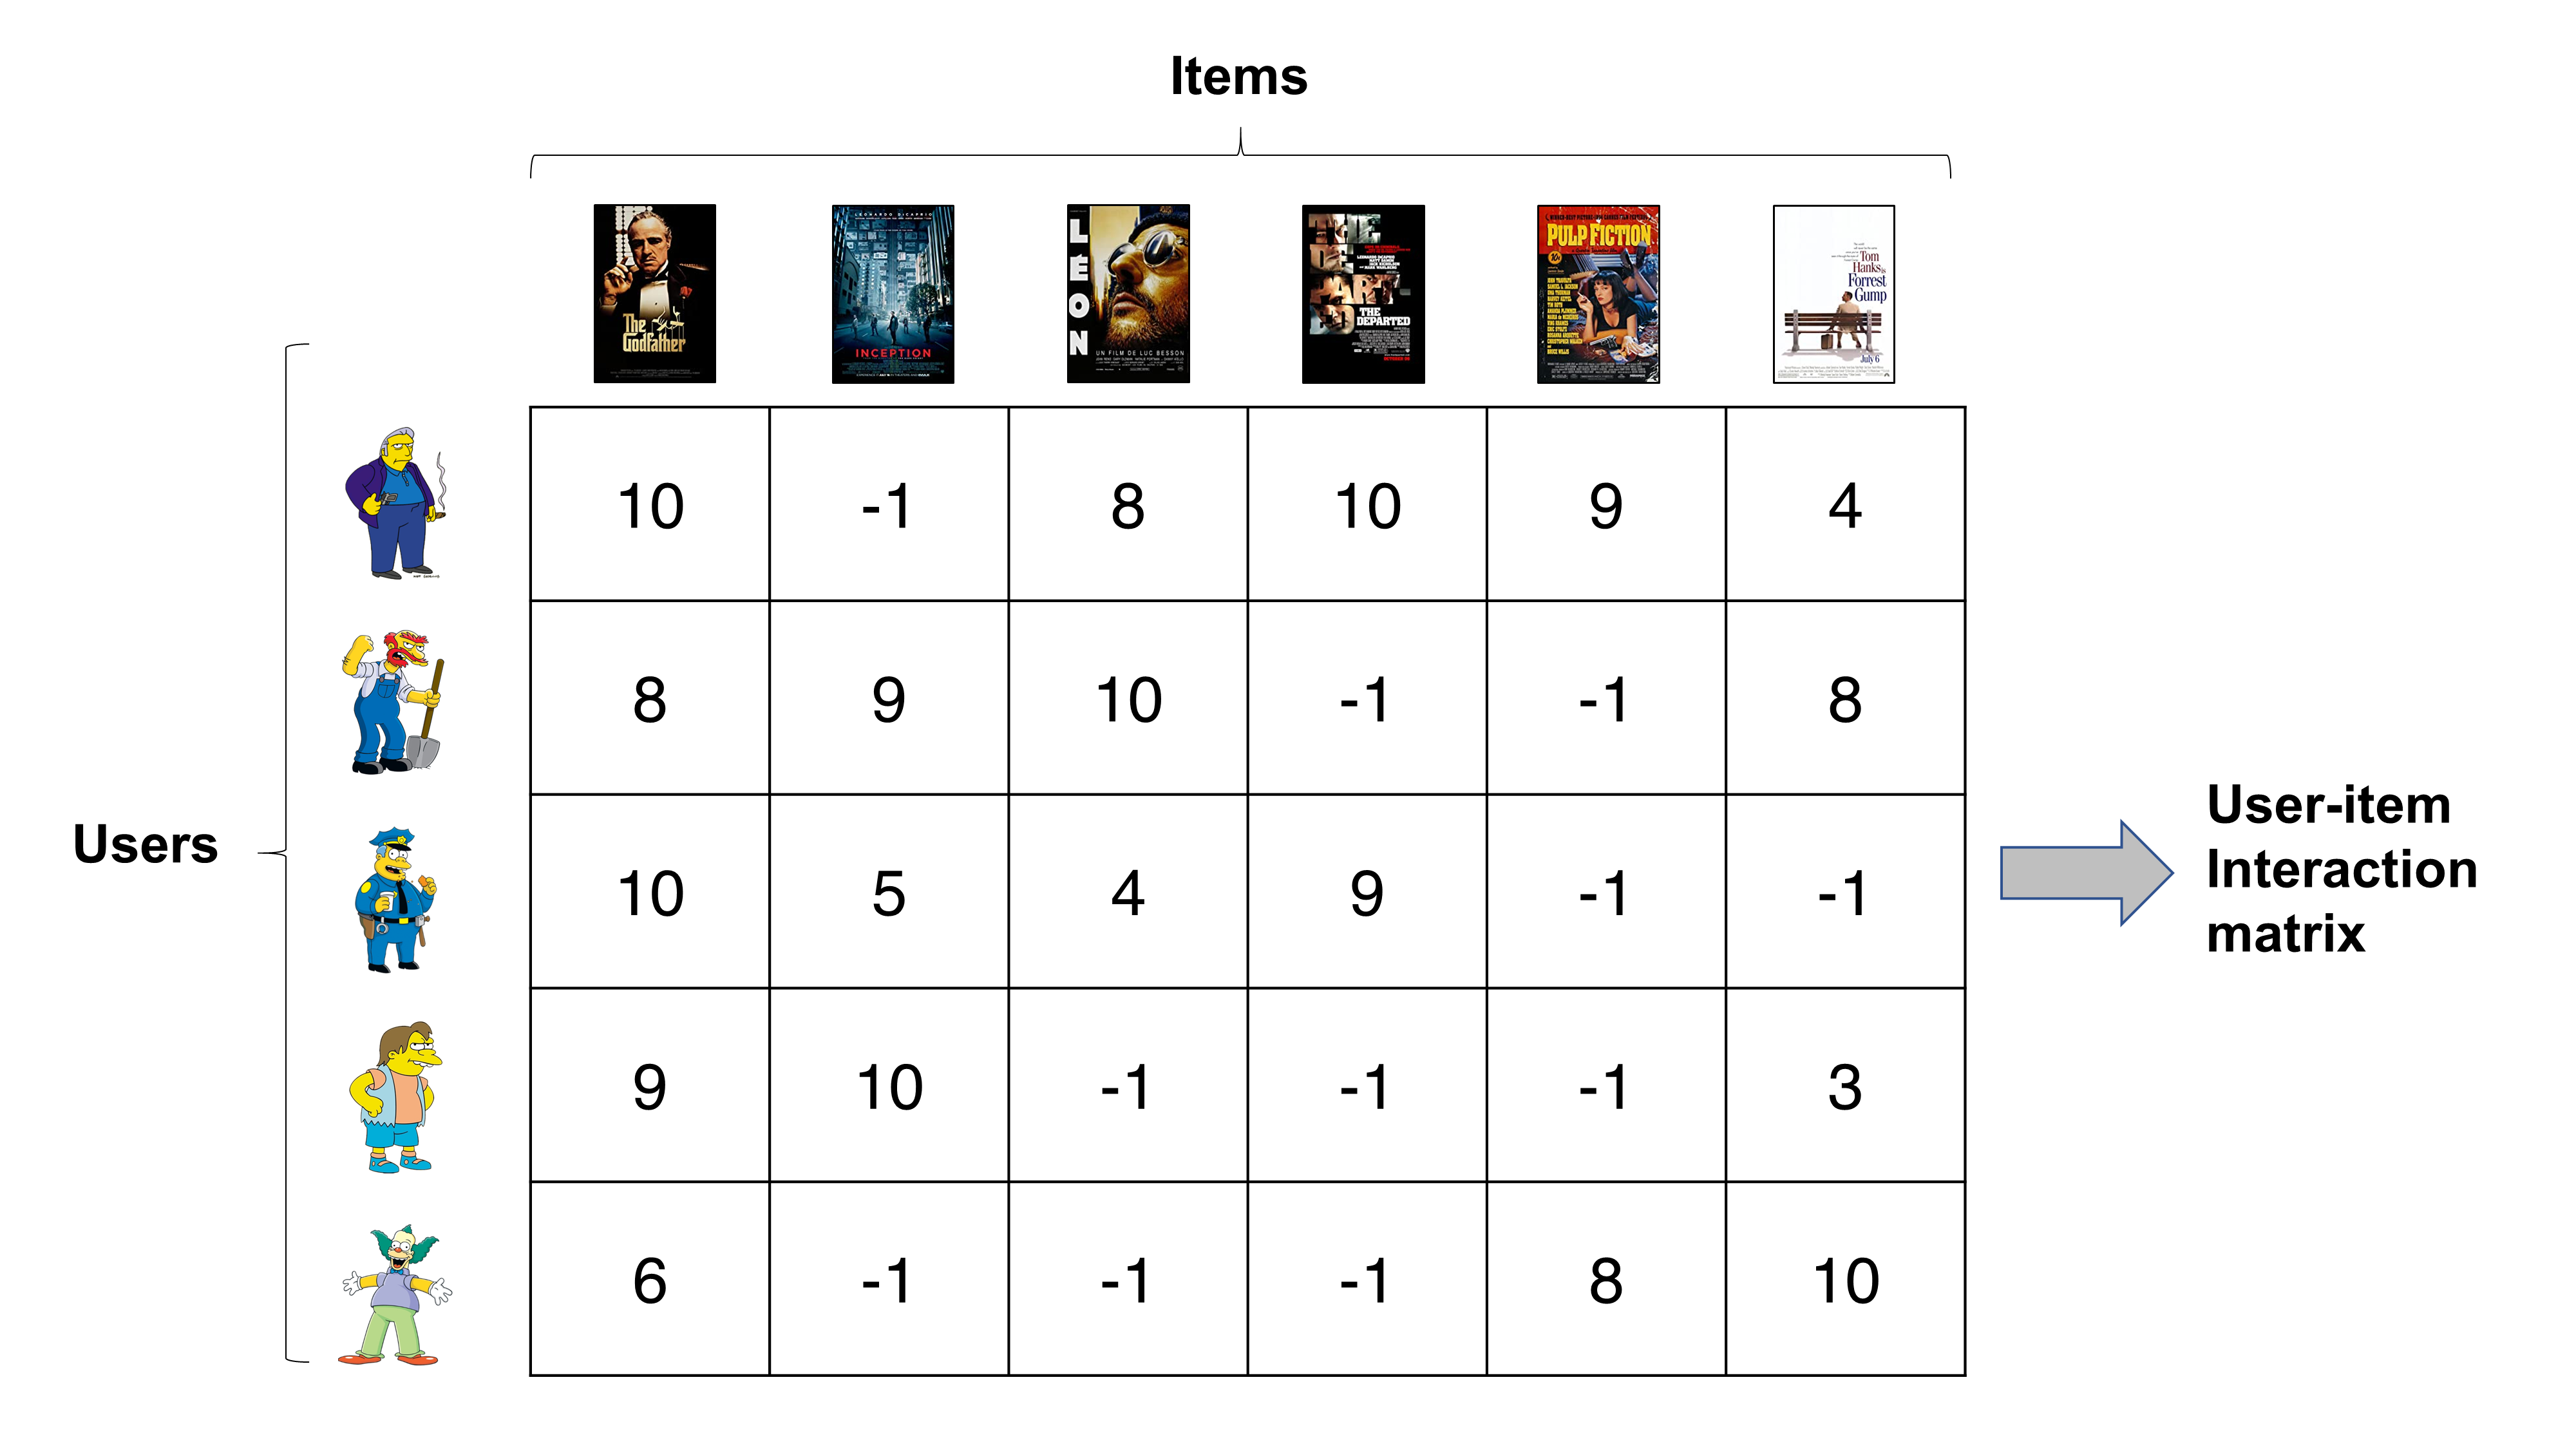

In [179]:
moviesdf['id'].head(3)

0      862
1     8844
2    15602
Name: id, dtype: object

In [180]:
ratingsdf['movieId'].head(3)

0      31
1    1029
2    1061
Name: movieId, dtype: int64

In [181]:
# rename column movieId as id for merging both dataframes
ratingsdf.columns=['userId','id','rating','timestamp']

In [182]:
#convert it to numeric in moviesdf
moviesdf['id']=pd.to_numeric(moviesdf['id'],errors="coerce")

In [183]:
# Inner Join of both dataframes
moviesdf_merge=moviesdf.merge(ratingsdf,on="id")

In [184]:
moviesdf_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44994 entries, 0 to 44993
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  44994 non-null  object 
 1   belongs_to_collection  10793 non-null  object 
 2   budget                 44994 non-null  object 
 3   genres                 44994 non-null  object 
 4   homepage               10959 non-null  object 
 5   id                     44994 non-null  float64
 6   imdb_id                44994 non-null  object 
 7   original_language      44994 non-null  object 
 8   original_title         44994 non-null  object 
 9   overview               44857 non-null  object 
 10  popularity             44994 non-null  object 
 11  poster_path            44958 non-null  object 
 12  production_companies   44994 non-null  object 
 13  production_countries   44994 non-null  object 
 14  release_date           44965 non-null  object 
 15  re

In [185]:
# Create User Item Matrix using pivot_table()
user_item_matrix=moviesdf_merge.pivot_table(index=['userId'],columns=['title'],
                                            values="rating",aggfunc="mean").fillna(0)

# User Item Matrix is sparse matric that has many zeroes

In [186]:
# To check which movies are rated by usedId 10
user10_rate=user_item_matrix.loc[10]
print(len(user10_rate[user10_rate>0].index.tolist()))

21


In [187]:
print(user10_rate[user10_rate>0].index.tolist())

['A Brief History of Time', 'A Very Long Engagement', 'André Hazes, Zij Gelooft in Mij', 'Bang, Boom, Bang', 'Dr. Jekyll and Mr. Hyde', 'Eyes Wide Shut', 'Hostel', 'Marie Antoinette', 'Point Break', 'Princesses', 'Spanglish', 'Star Trek: The Motion Picture', 'Teenage Mutant Ninja Turtles III', 'The Addams Family', 'The Breakfast Club', 'The Conversation', 'The Million Dollar Hotel', 'The Miracle of Bern', 'The Soft Skin', 'The Three Musketeers', 'Twin Peaks: Fire Walk with Me']


In [188]:
user_item_matrix.shape

(671, 2794)

In [189]:
moviesdf_merge['vote_count'].groupby(moviesdf_merge['title']).sum().nlargest(20)

title
Titanic                                                   1144980.0
Men in Black II                                            714112.0
Terminator 3: Rise of the Machines                         705348.0
Reservoir Dogs                                             584613.0
Jurassic Park                                              564984.0
Back to the Future Part II                                 557492.0
Star Wars                                                  555796.0
Scarface                                                   356006.0
A Clockwork Orange                                         350064.0
Rain Man                                                   348876.0
Batman Returns                                             341200.0
Donnie Darko                                               332382.0
Ocean's Eleven                                             309824.0
The Bourne Supremacy                                       304538.0
Harry Potter and the Prisoner of Azkaban  

In [190]:
# Different Methods are used for identifying collaborative similarity
# 1) Nearest Neighbors (Euclidean Distance) ;2) Singular Value Decomposition 
# 3) Non Matrix Factorization

In [191]:
from sklearn.neighbors import NearestNeighbors

In [221]:
cf_nn_model=NearestNeighbors(metric="euclidean",algorithm="brute",n_neighbors=10,
                             n_jobs=-1).fit(user_item_matrix.T)

In [223]:
def get_recommend(movie_title, n_recommends=10):
    if movie_title not in user_item_matrix.columns:
        return "Movie not found"
    
    movie_idx = user_item_matrix.columns.get_loc(movie_title)
    
    # Ensure input shape is correct
    distances, indices = cf_nn_model.kneighbors(
        user_item_matrix.T.iloc[movie_idx].values.reshape(1, -1),
        n_neighbors=n_recommends + 1  # +1 to exclude itself
    )

    # Fix: Use columns (movie titles) instead of index
    recommended_movies = [user_item_matrix.columns[i] for i in indices.flatten()[1:]]  # Skip itself
    return recommended_movies

In [225]:
get_recommend('The Matrix')

['Shock Treatment',
 'King of California',
 'The Matrix',
 'Fire Birds',
 'Life',
 'Snow White and the Seven Dwarfs',
 'My Best Fiend',
 'Alive',
 "It Happened at the World's Fair",
 'Highlander']

In [229]:
# Content Based Recommender System
moviesdf['overview']=moviesdf['overview'].fillna("")

In [231]:
moviesdf['overview']=moviesdf['overview'].str.lower()

In [233]:
from sklearn.feature_extraction.text import CountVectorizer

In [235]:
DTM=CountVectorizer(max_features=200,stop_words="english",ngram_range=(2,2))

In [237]:
X_DTM=DTM.fit_transform(moviesdf['overview'])

In [239]:
from sklearn.metrics.pairwise import linear_kernel

In [241]:
cosine_sim=linear_kernel(X_DTM,X_DTM)

In [243]:
indices=pd.Series(moviesdf.index,index=moviesdf['title']).drop_duplicates()

In [245]:
def get_recommend(title,cosine_sim=cosine_sim):
    idx=indices[title]
    sim_scores=list(enumerate(cosine_sim[idx]))
    sim_scores=sorted(sim_scores,key=lambda x:x[1],reverse=True)
    sim_scores=sim_scores[1:11]
    movie_indices=[i[0] for i in sim_scores]
    return moviesdf.title.iloc[movie_indices]

In [281]:
get_recommend("Jumanji")

4746                       Thir13en Ghosts
12169    The Diving Bell and the Butterfly
13029                           Quarantine
17260                              Private
20153                            Extracted
31835                       The Last Light
34346                           Septic Man
43127                              The Bar
21345                        The Last Days
40600                    Terminal Invasion
Name: title, dtype: object

In [251]:
# Hybrind Model - Both Content Based with Singular Value Decomposition
from sklearn.feature_extraction.text import TfidfVectorizer

In [263]:
tfidf=TfidfVectorizer(max_features=3000,stop_words="english",ngram_range=(2,2))

In [265]:
X_tfidf=tfidf.fit_transform(moviesdf['overview'])

In [266]:
from sklearn.decomposition import TruncatedSVD

In [267]:
svd=TruncatedSVD(n_components=100,random_state=42)

In [268]:
svd_matrix=svd.fit_transform(X_tfidf)

In [273]:
from sklearn.metrics.pairwise import cosine_similarity

In [275]:
cosine_sim=cosine_similarity(svd_matrix)

In [277]:
def get_recommend(title,cosine_sim=cosine_sim):
    idx=indices[title]
    sim_scores=list(enumerate(cosine_sim[idx]))
    sim_scores=sorted(sim_scores,key=lambda x:x[1],reverse=True)
    sim_scores=sim_scores[1:11]
    movie_indices=[i[0] for i in sim_scores]
    return moviesdf.title.iloc[movie_indices]

In [279]:
get_recommend("Jumanji")

4746                       Thir13en Ghosts
12169    The Diving Bell and the Butterfly
13029                           Quarantine
17260                              Private
20153                            Extracted
31835                       The Last Light
34346                           Septic Man
43127                              The Bar
21345                        The Last Days
40600                    Terminal Invasion
Name: title, dtype: object